In [1]:
import os
import argparse
import wandb
import re
import clip
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# add the parent directory to the path
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
                
from utils.gcbm import *



/home/pknab/miniconda3/envs/envi/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-11-01 17:42:55.890673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-01 17:42:55.890723: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
# ----------------- Fix -----------------
embed_path = "../Embeddings/"
dataset = "imagewoof"
class_labels_path = None
segment_path = "../Segments/Seg_embs/"
selected_image_concepts = "../Embeddings/subsets"
raw_path_dataset = # TODO
raw_path = #TODO: Define the path to the raw images

# ----------------- Hyperparameters -----------------

model_name = "CLIP-ViT-B16"  # "CLIP-ViT-L14", "CLIP-RN50"

segmentation_technique = "SAM"  # GDINO, SAM, SAM2, DETR, MaskRCNN
raw_path = "../Segments/ImageWoof_SAM/crops"  # adapt to path of raw segments
concept_name = None  # Define for GDINE [awa, sun, sun-lowthresh, cub...]

device = "cuda:0"

clusters = 256
cluster_method = "kmeans"  # "hierarchical", "kmeans"
centroid_method = "median"  # "mean", "median"

concept_per_class = 50  # How many images for each class 5,10,20,50, None

one_hot = False
epochs = 200
lambda_1 = 1e-4
lr = 1e-4
batch_size = 32

crop = False  # True without background

use_wandb = False
project = "SegCBM_ALL"  # Define your own project name within wandb

In [ ]:
cbm = CBM(
    embed_path, dataset, model_name, class_labels_path, device=device
)  # Initialize CBM

cbm.load_concepts(
    segment_path,
    segmentation_technique,
    concept_name,
    selected_image_concepts,
    concept_per_class,
    crop=crop,
)  # Load concepts with predefined segmentation technique and hyperparameters

if clusters is not None:  # if clustering is needed
    cbm.cluster_image_concepts(cluster_method, clusters)
else:
    cbm.clustered_concepts = cbm.image_segments

cbm.centroid_concepts(
    centroid_method
)  # Calculate centroids of the concepts with given method

cbm.preprocess_data(
    type_="standard", label_type=one_hot
)  # preprocess data for training
cbm_model = cbm.train(  # train the model
    num_epochs=epochs,
    lambda_1=lambda_1,
    lr=lr,
    batch_size=batch_size,
    device=device,
    project=project,
    to_print=False,
    early_stopping_patience=None,
    one_hot=one_hot,
    use_wandb=use_wandb,
)

In [ ]:
model = CBM_Model(
    cbm_model, cbm.clustered_concepts, cbm.preprocess_module, cbm.scaler, device=device
)
print("Predictions: ")
print(model.predict_processed(cbm.X_test[:200]))
print("True Classes: ")
print(np.argmax(cbm.y_test[:200], axis=1))

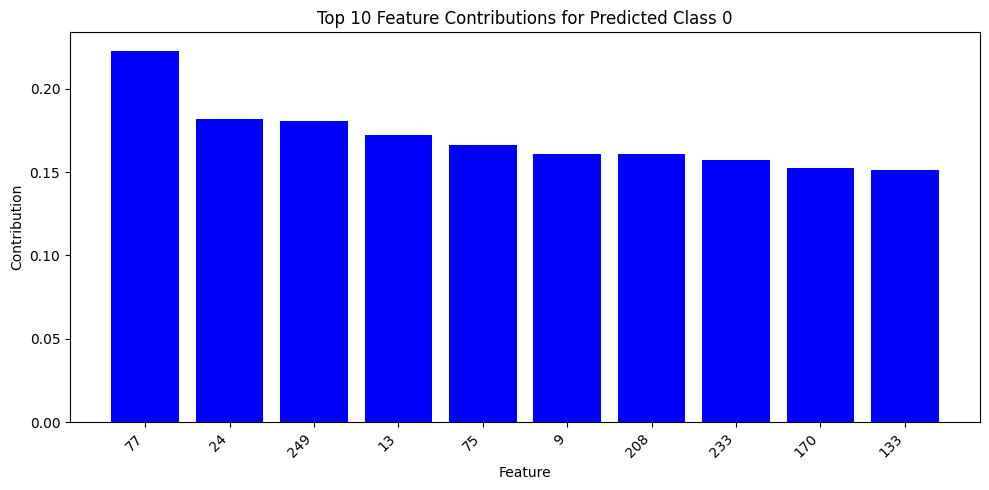

True Class: Shih-Tzu
Predicted Class: Shih-Tzu


In [ ]:
id_image = 2000

concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

In [ ]:
model, preprocess = clip.load("ViT-L/14", device=device, jit=False)

with open("..data/classes/20k.txt", "r") as f:
    g20k = f.readlines()
names = [i.strip() for i in g20k]
tokenized_text = clip.tokenize(names).to(device)

with torch.no_grad():
    text_features = model.encode_text(tokenized_text)
        

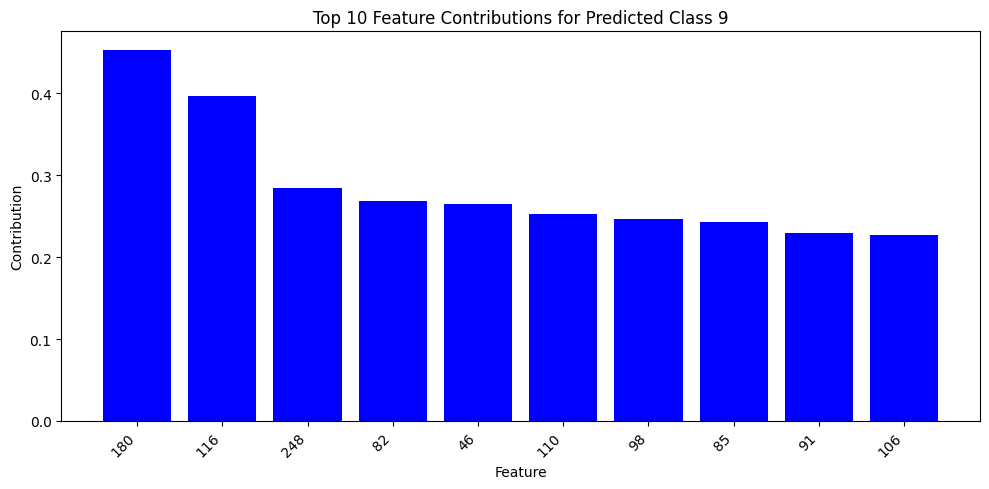

True Class: Dingo
Predicted Class: Dingo


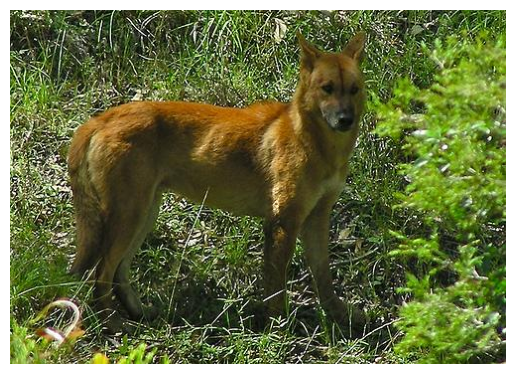

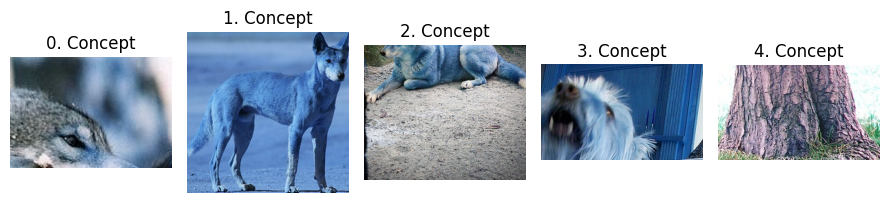

In [ ]:
def display_images_with_main(image_paths, main_image_path, concept_names, num_secondary=5):
    """
    Display a main image prominently and a series of smaller images in a row layout.

    Parameters:
    - image_paths (list): List of file paths for the secondary images.
    - main_image_path (str): File path of the main image to be displayed larger.
    - num_secondary (int): Number of secondary images to display. Default is 5.
    """
    # Remove duplicates from image paths
    image_paths = list(dict.fromkeys(image_paths))[:num_secondary]

    # Display the main image
    main_img = Image.open(main_image_path)
    plt.imshow(main_img)
    plt.axis("off")

    # Set up the grid: main image in a larger size, followed by smaller images
    fig, axes = plt.subplots(1, num_secondary, figsize=(9, 4))

    # Display each of the secondary images
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(concept_names[i])

    plt.tight_layout()
    plt.show()


def display_concepts(id_image, cbm, raw_path, raw_path_dataset):

    concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

    # Get the main image path
    image_name = list(cbm.data_test_raw.keys())[id_image]
    folder_name = image_name.split("_")[0]
    image_path_org = os.path.join(raw_path_dataset, folder_name, image_name) + ".JPEG"

    # Find paths to median images based on feature importance (as in your example)
    image_median_paths = []
    concept_names = []
    for idx in concept_ids[:5]:
        idx = int(idx)
        clustered_concepts = cbm.clustered_concepts_all
        data = clustered_concepts[idx]
        median_values = np.median(data, axis=0)
        distances = np.sum(np.abs(data - median_values), axis=1)
        median_index = np.argmin(distances)
        clustered_images = cbm.image_segments_names
        median_index = np.argsort(distances)

        # Select up to n images closest to median
        n = 20
        median_entries = [clustered_images[idx][i] for i in median_index[:n]]
        
        concept_emb = data[median_index[0]]
        concept_emb = torch.tensor(concept_emb).to(device)
        sim = torch.nn.functional.cosine_similarity(concept_emb, text_features).cpu().float()

        top_index = sim.argsort(descending=True)
        concept_names.append(names[top_index[0]])

        # Process and add paths for the secondary images
        def extract_until_number(strings):
            def process_string(s):
                return s if "ILSVRC2012" not in s else None

            return [x for x in map(process_string, strings) if x]

        image_median_paths.append(extract_until_number(median_entries)[0])

    # Construct full paths for secondary images
    image_paths = [
        os.path.join(raw_path, name.split("_")[0], name) for name in image_median_paths
    ]

    # Call the function to display images
    display_images_with_main(image_paths, image_path_org, concept_names)


# Example usage:
id_image = 405

display_concepts(id_image, cbm, raw_path, raw_path_dataset)